In [18]:
from __future__ import division

from faculty_hiring.misc.util import *
from faculty_hiring.misc.plotting import *  # Definitions for LABEL_SIZE, colors, etc.
from faculty_hiring.misc.productivity import *
from faculty_hiring.parse import faculty_parser, institution_parser
from faculty_hiring.parse import load
from faculty_hiring.misc.subfield import topic_descriptions, longer_topic_descriptions, num_topics 

import numpy as np
import scipy as sp
import palettable
import pickle

from scipy.stats.stats import pearsonr, mannwhitneyu, ttest_ind
from scipy.stats import ttest_ind, ks_2samp, chi2_contingency, mannwhitneyu
from collections import Counter

In [19]:
faculty_file = '/Users/allisonmorgan/Documents/faculty_hiring/publication_data/current_data/faculty_cs_CURRENT.txt'
inst_file = '/Users/allisonmorgan/Documents/faculty_hiring/publication_data/current_data/inst_cs_CURRENT.txt'
figures_dir = '/Users/allisonmorgan/Code/src/github.com/allisonmorgan/faculty_hiring/notebooks-productivity/figures/'

# Path to prepped DBLP pickles
dblp_dir = '/Users/allisonmorgan/Documents/faculty_hiring/publication_data/profiles_DBLP_Nov16/'

In [20]:
inst = institution_parser.parse_institution_records(open(inst_file))
asst_faculty = load.load_assistant_profs(open(faculty_file), inst, ranking='pi')
load.load_all_publications(asst_faculty, dblp_dir)  # This takes a minute..

# Total Number of Publications

In [21]:
# Number of publications for all current assistant faculty of a university. Adjusted for inflation
# Set limit_by_years_post_hire flag to True to consider only the contributions within the first 5 
# years of a researcher's career.
limit_by_years_post_hire = True
ignore = ['All others', 'UNKNOWN', 'CUNY Graduate Center']
pubs_by_inst = {}
pubs_by_year_by_inst = {}
for (name, inst_data) in inst.items():
    if name in ignore:
        continue
    current_faculty = faculty_at_institution(name, asst_faculty)
    n_pubs = []; n_pubs_by_year = [];
    for person in current_faculty:
        start = person.first_asst_job_year
        if limit_by_years_post_hire:
            end = np.min([2012, person.first_asst_job_year + 5])
        else:
            end = 2012
        career_length = end - start
        
        if person.__contains__('dblp_pubs'):
            contribution = 0
            for pub in person.dblp_pubs:
                if 'year' in pub \
                      and pub['year'] >= start \
                      and pub['year'] < end \
                      and pub['pub_type'] in ['inproceedings', 'article']:
                    contribution += inflation_adjust(pub['year'])
            
            n_pubs.append((person.facultyName, contribution))
            n_pubs_by_year.append((person.facultyName, contribution/float(career_length)))
    if len(n_pubs) > 0:
        pubs_by_inst[name] = n_pubs
        pubs_by_year_by_inst[name] = n_pubs_by_year

In [22]:
print(pubs_by_year_by_inst['Stanford University'][0], pubs_by_inst['Stanford University'][0])

(('Alex Aiken', 6.103980993217104), ('Alex Aiken', 30.51990496608552))


In [23]:
# Plot of differences in productivity from the mean
def plot_distribution_of_productivity(data):
    diffs = []
    for (name, n_pubs) in data.items():
        counts = [np.log(pubs + 1) for _, pubs in n_pubs]
        
        avg = np.mean(counts)
        diffs.extend([(count - avg) for count in counts])
    
    print(sp.stats.mstats.normaltest(diffs))
        
    fig, ax = plt.subplots(1,1, figsize=SINGLE_FIG_SIZE)
    plt.hist(diffs)
    plt.show()

NormaltestResult(statistic=32.000113130779503, pvalue=1.1252880930327313e-07)


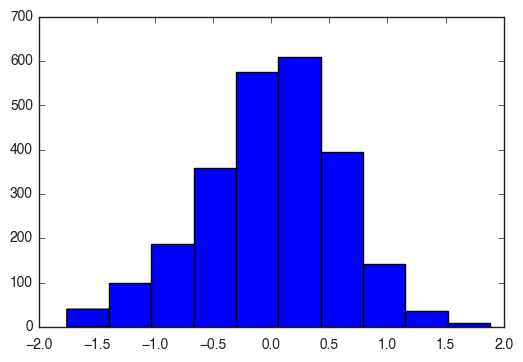

In [24]:
plot_distribution_of_productivity(pubs_by_year_by_inst)

### Prestige

The following two plots shows the median number of publications per faculty (adjusted for inflation). 
Two lines are fit through private and public university medians respectively.

In [25]:
pickle.dump(pubs_by_year_by_inst, open('pubs_by_inst.p', "wb"))

                            OLS Regression Results                            
Dep. Variable:                   pubs   R-squared:                       0.356
Model:                            OLS   Adj. R-squared:                  0.353
Method:                 Least Squares   F-statistic:                     111.0
Date:                Mon, 19 Dec 2016   Prob (F-statistic):           6.00e-21
Time:                        19:17:27   Log-Likelihood:                -634.66
No. Observations:                 203   AIC:                             1273.
Df Residuals:                     201   BIC:                             1280.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     21.3478      0.853     25.033      0.0

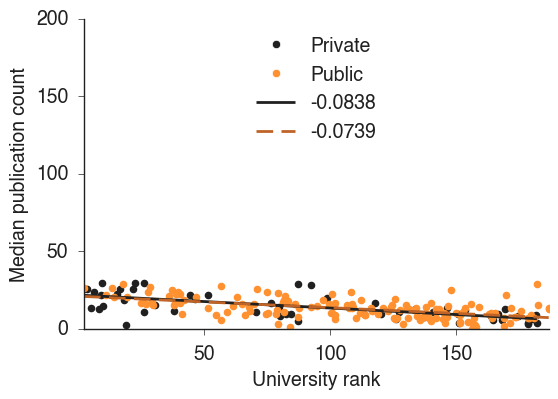

In [26]:
plot_pubs_versus_prestige(pubs_by_inst, 'Median publication count', function=np.median)

                            OLS Regression Results                            
Dep. Variable:                   pubs   R-squared:                       0.321
Model:                            OLS   Adj. R-squared:                  0.318
Method:                 Least Squares   F-statistic:                     95.12
Date:                Mon, 19 Dec 2016   Prob (F-statistic):           1.20e-18
Time:                        19:17:28   Log-Likelihood:                -318.29
No. Observations:                 203   AIC:                             640.6
Df Residuals:                     201   BIC:                             647.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      4.4329      0.179     24.700      0.0

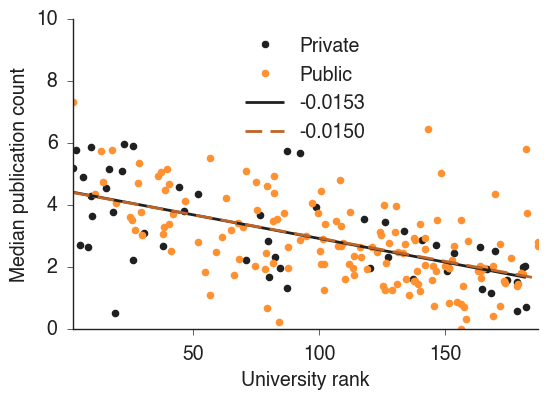

In [27]:
plot_pubs_versus_prestige(pubs_by_year_by_inst, 'Median publication count', function=np.median, ylim=(0,10))

# Fractional Author Contribution

In [ ]:
"""
# Fractional contribution of publications for all current assistant faculty of a university
frac_pubs_by_inst = {};
for (name, inst_data) in inst.items():
    if name in ignore:
        continue
    current_faculty = faculty_at_institution(name, asst_faculty)
    frac_n_pubs = []
    for person in current_faculty:
        start = person.first_asst_job_year
        if person.__contains__('dblp_pubs'):            
            frac_contribution = 0
            for pub in person.dblp_pubs:
                if 'year' in pub and pub['year'] >= start and pub['year'] < 2012 and pub['pub_type'] in ['inproceedings', 'article']:
                    frac_contribution += inflation_adjust(pub['year'])/float(len(pub['authors']))
            frac_n_pubs.append((person.facultyName, frac_contribution))
            
    if len(n_pubs) > 0:
        frac_pubs_by_inst[name] = frac_n_pubs
"""

### Prestige

In [ ]:
#plot_pubs_versus_prestige(frac_pubs_by_inst, 'Fractional Contribution', function=np.median, percentiles=True, fit=True, private=True)

# Exclude Middle Author Role From Number of Publications

In [ ]:
"""
# Number of publications for all current assistant faculty of a university
first_and_last_pubs_by_inst = {}
for (name, inst_data) in inst.items():
    if name in ignore:
        continue
    current_faculty = faculty_at_institution(name, asst_faculty)
    n_pubs = []
    for person in current_faculty:
        start = person.first_asst_job_year
        if person.__contains__('dblp_pubs'):
            first_and_last_contributions = 0
            for pub in person.dblp_pubs:
                if 'year' in pub and pub['year'] >= start and pub['year'] < 2012 and pub['pub_type'] in ['inproceedings', 'article']:
                    if pub['author_role'] != 1:
                        first_and_last_contributions += inflation_adjust(pub['year'])
            n_pubs.append((person.facultyName, first_and_last_contributions))
    
    if len(n_pubs) > 0:
        first_and_last_pubs_by_inst[name] = n_pubs
"""

### Prestige

In [ ]:
#plot_pubs_versus_prestige(first_and_last_pubs_by_inst, 'Number of FAP & LAP', function=np.median, percentiles=True, fit=True, private=True)